# 猫狗大战

本节使用的数据集来自 Kaggle 网站上的“Dogs vs. Cats ” 竞赛项目。在这个数据集的训练数据集中一共有 25000 张猫和狗的图片，其中包含 12500 张猫的图片和 12500 张狗的图片。在测试数据集中有12500 张图片，不过其中的猫狗图片是无序混杂的，而且没有对应的标签。这些数据集将被用于对模型进行训练和对参数进行优化，以及在最后对模型的泛化能力进行验证。

在本实践中我们分别从训练数据集的猫和狗的图片中各抽出 2500 张图片组成一个具有5000 张图片的验证数据集。 我们也可以将验证数据集看作考试中的模拟训练测试，将测试数据集看作考试中的最终测试，通过两个结果看测试的整体能力，但是测试数据集最后会有绝对的主导作用。不过本节使用的测试数据集是没有标签的，而且本节旨在证明迁移学习比传统的训练高效，所以暂吋不使用在数据集中提供的测试数据集，我们进行的只是模型对验证数据集的准确性的横向比较。

新建一个名为 DogsVSCats 的文件夹，在该文什夹下面新建一个名为 train和一个名为valid 的子文件夹，在子文件夹下面再分别新建一个名为cat 的文件夹和一个名为dog 的文件夹，最后将数据集中对应部分的数据放到对应名字的文件夹中，之后就可以进行数据的载入了。

目录结构如下：
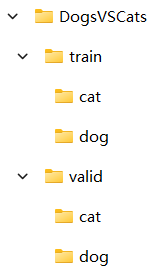

## 1、数据预览

In [34]:
import torch
import torchvision
from torchvision import datasets,models,transforms
import os
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable

In [35]:
data_dir="C:\\Users\\Administrator\\Desktop\\dogcat\\PetImages"
data_transform={x:transforms.Compose([transforms.Resize([64,64]),
                                     transforms.ToTensor()])
               for x in ["train","valid"]}
# root=os.path.join(data_dir,x)
image_datasets={x: datasets.ImageFolder(root=os.path.join(data_dir,x),
                                       transform=data_transform[x])
               for x in ["train","valid"]}
dataloader={x:torch.utils.data.DataLoader(dataset=image_datasets[x],
                                         batch_size=16,
                                         shuffle=True)
           for x in ["train","valid"]}

 在进行数据的载入时我们使用 torch.transforms 中的 Resize类将原始图片的大小统一缩放至 64×64。在以上代码中对数据的变换和导入都使用了字典的形式，因为我们需要分别对训练数据集和验证数据集的数据载入方法进行简单定义，所以使用字典可以简化代码，也方便之后进行相应的调用和操作。 os.path.join 就是来自之前提到的 os 包的方法，它的作用是将输入参数中的两个名字拼接成一个完整的文件路径。

In [36]:
#获取一批次的数据进行预览和分析
X_example,y_example=next(iter(dataloader["train"]))
print(X_example.shape)
print(y_example)

torch.Size([16, 3, 64, 64])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1])


 y_example 也是Tensor 数据类型的变量，不过其中的元素全部是0和1,这是因为在进行数据装载时己经对 dog 文件夹和 cat 文件夹下的内容进行了独热编码 （One-Hot Encoding)，所以这时的0和1不仅是每张图片的标签，还分别对应猫的图片和狗的图片。我们可以做一个简单的打印输出，来验证这个独热编码的对应关系

In [37]:
index_classes=image_datasets["train"].class_to_idx
print(index_classes)

{'cat': 0, 'dog': 1}


这样就很明显了，猫的图片标签和狗的图片标签被独热编码后分别被数字化了，相较于使用文字作为图片的标签而言，使用0 和1也可以让之后的计算方便很多。不过，为了增加之后绘制的图像标签的可识别性，将原始标签的结果存储在名为example_clasces 的变量中。

In [38]:
example_classes=image_datasets["train"].classes
print(example_classes)

['cat', 'dog']


['cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog']


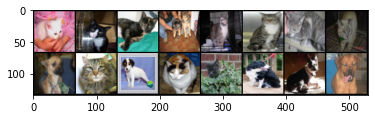

In [39]:
img=torchvision.utils.make_grid(X_example)  #将多张图片组合成一张图片
img=img.numpy().transpose([1,2,0])
print([example_classes[i] for i in y_example])
plt.imshow(img)
plt.show()

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
device='cpu'
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

for param in model_ft.parameters():
    param.requires_grad=False

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
fparam=0
tparam=0
for param in model_ft.parameters():
    if param.requires_grad==False:
        fparam+=1
    else:
        tparam+=1
print('fparam:',fparam)
print('tparam:',tparam)
# 定义优化器和学习率策略
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 训练模型
num_epochs = 10
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs - 1}")
    print("-" * 10)

    # 迭代训练集和验证集
    for phase in ['train', 'valid']:
        if phase == 'train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        # 迭代数据集
        for inputs, labels in dataloader[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 梯度重置为0
            optimizer_ft.zero_grad()

            # 前向传播
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # 反向传播和优化
                if phase == 'train':
                    loss.backward()
                    optimizer_ft.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # 计算损失和准确率
        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # 保存最佳模型
        if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model_ft.state_dict(), 'best_model.pth')
    
    # 学习率调度
    exp_lr_scheduler.step()

print(f"Best val Acc: {best_acc:.4f}")


fparam: 60
tparam: 2
Epoch 0/9
----------
train Loss: 0.6701 Acc: 0.6445
valid Loss: 0.5571 Acc: 0.7190
Epoch 1/9
----------
train Loss: 0.5859 Acc: 0.7115
valid Loss: 0.6430 Acc: 0.7080
Epoch 2/9
----------
train Loss: 0.5293 Acc: 0.7380
valid Loss: 0.6456 Acc: 0.6840
Epoch 3/9
----------
train Loss: 0.5646 Acc: 0.7220
valid Loss: 0.5994 Acc: 0.7270
Epoch 4/9
----------
train Loss: 0.5457 Acc: 0.7400
valid Loss: 0.5330 Acc: 0.7260
Epoch 5/9
----------
train Loss: 0.5346 Acc: 0.7345
valid Loss: 0.6756 Acc: 0.6990
Epoch 6/9
----------
train Loss: 0.5296 Acc: 0.7510
valid Loss: 0.5763 Acc: 0.6980
Epoch 7/9
----------
train Loss: 0.4976 Acc: 0.7555
valid Loss: 0.5275 Acc: 0.7320
Epoch 8/9
----------
train Loss: 0.4877 Acc: 0.7645
valid Loss: 0.5314 Acc: 0.7440
Epoch 9/9
----------
train Loss: 0.4718 Acc: 0.7825
valid Loss: 0.5246 Acc: 0.7400
Best val Acc: 0.7440
